# Industry sector & Education
### Microdati di Banca d'Italia
Indagine sui Bilanci delle Famiglie Italiane (**BFI**)

In [1]:
import os
import polars as pl
from BI_microdata_extractor import BIMicrodataExtractor

bfi = BIMicrodataExtractor()
bfi.load_data("BFI_2022")

Attributi:
- STUDIO: Titolo di studio
- NACE & NACE2: Settore di attività dell’azienda nella quale presta (NACE) o prestava (NACE2) la propria attività lavorativa principale.

In [ ]:
_=bfi.get_attribute_metadata("STUDIO",print_output=True)

In [374]:
_=bfi.get_attribute_metadata("NACE",print_output=True)

Attribute:
   NACE
Description:
   Settore di attività dell’azienda nella quale presta/prestava la propria attività lavorativa principale.
Encod.	Label
1	Agricoltura, silvicoltura e pesca
2	Attività estrattive
3	Attività manifatturiere
4	Fornitura di energia elettrica, gas, vapore e aria condizionata
5	Fornitura di acqua; reti fognarie, attività di trattamento dei rifiuti e risanamto
6	Costruzioni
7	Commercio all’ingrosso e al dettaglio, riparazioni di autoveicoli e motocicli
8	Trasporto e magazzinaggio
9	Servizi di alloggio e di ristorazione
10	Servizi di informazione e comunicazione
11	Attività finanziarie e assicurative
12	Attività immobiliari
13	Attività professionali, scientifiche e tecniche
14	Attività amministrative e di servizi di supporto
15	Amministrazione pubblica e difesa, assicurazione sociale obbligatoria
16	Istruzione
17	Sanità e assistenza sociale
18	Attività artistiche, di intrattenimento e divertimento
19	Altre attività di servizi
20	Attività di famiglie e convivenze 

In [ ]:
bfi.df_familymembers.filter((pl.col("NACE").is_not_null())&(pl.col("NACE2").is_not_null()))["NACE","NACE2"]

df_nace_ = bfi.df_familymembers.with_columns(
    pl.when(pl.col("NACE").is_not_null())
    .then(pl.col("NACE"))
    .otherwise(pl.col("NACE2"))
    .alias("NACE_")
).drop_nulls("NACE_")

In [431]:
df_sector_edu_distr,_ = bfi.joint_distribution(["NACE_","STUDIO"],df_nace_)

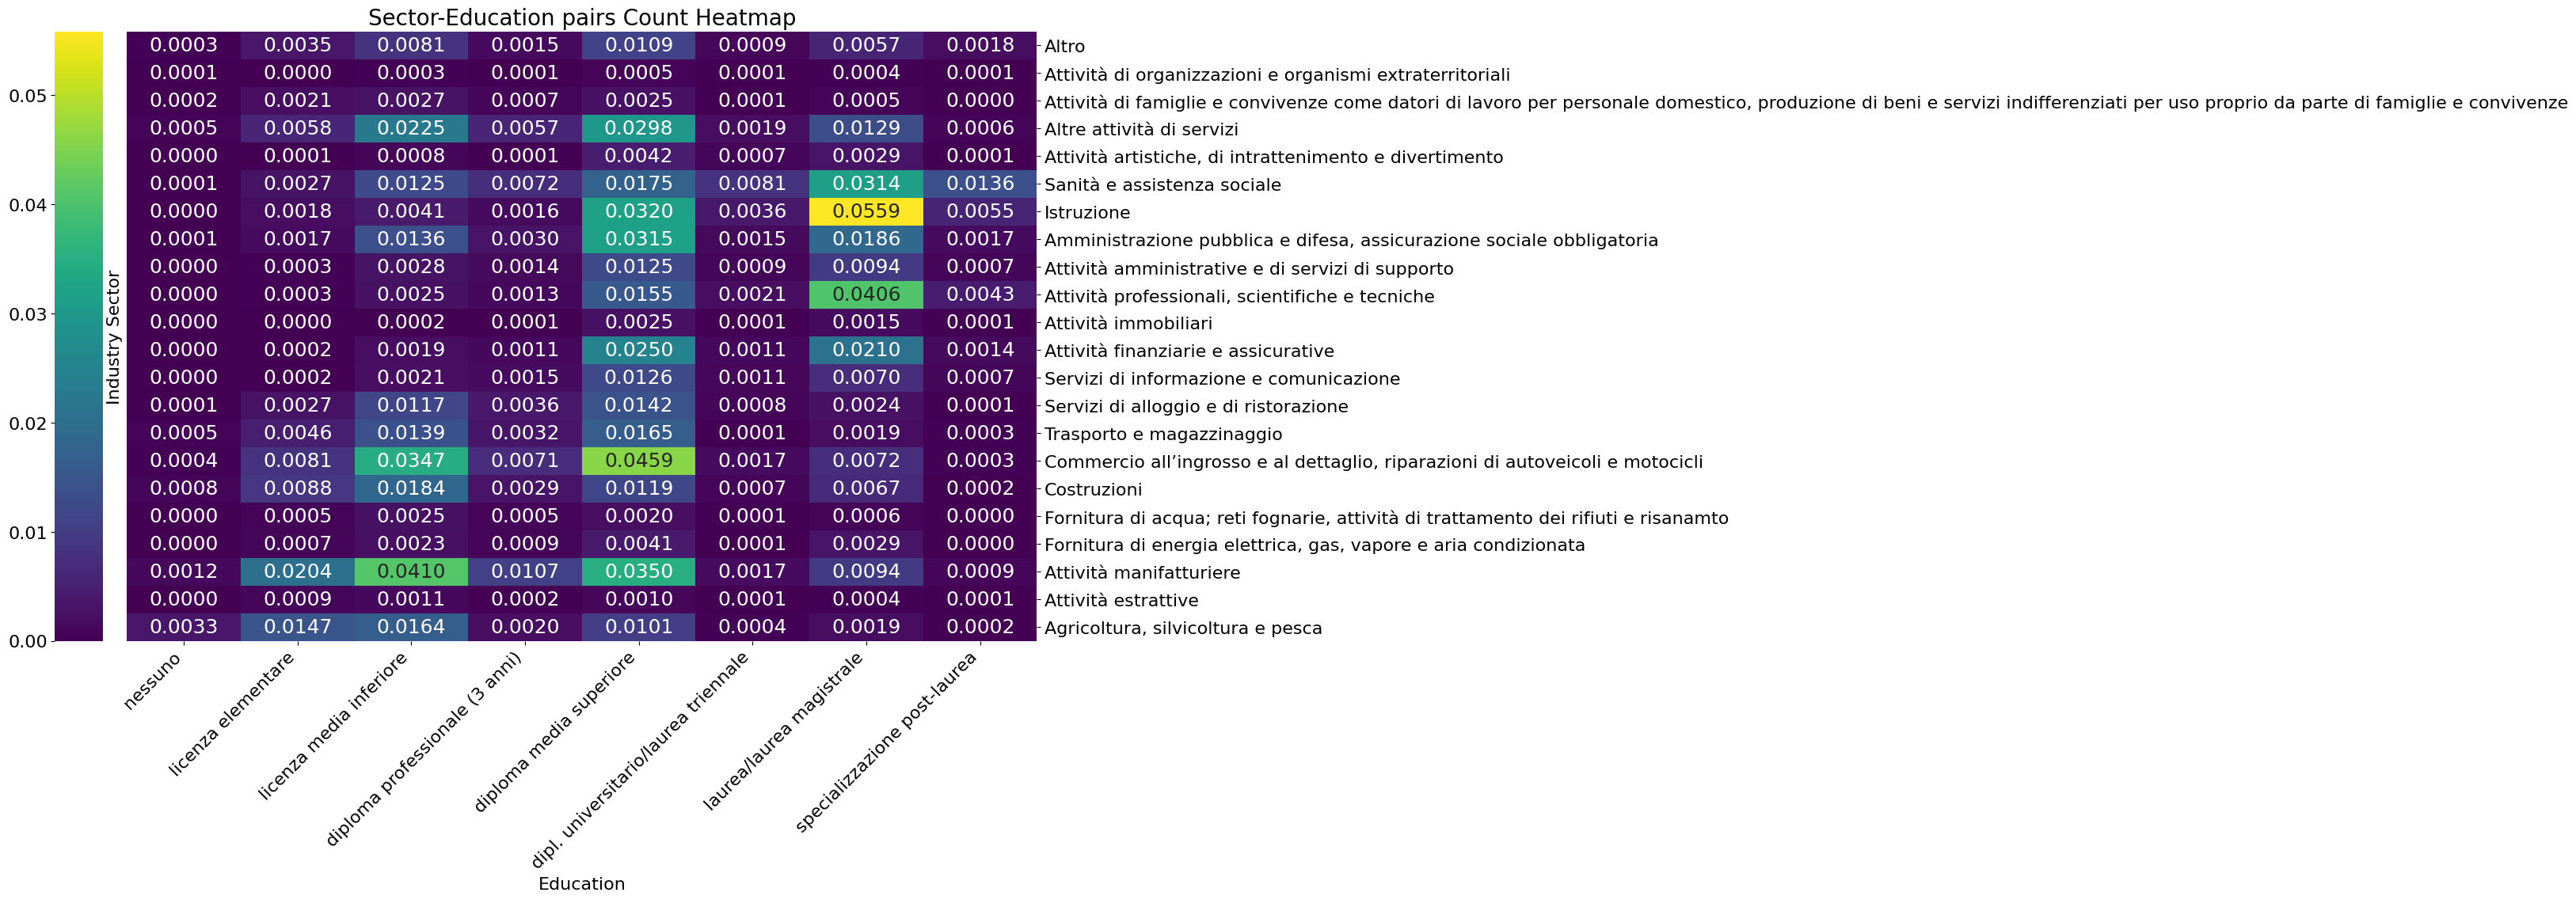

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Pivot: NACE_ as index (rows), STUDIO as columns
sector_edu_count = (
    df_sector_edu_distr.pivot(
        values="prob",
        index="NACE_",
        on="STUDIO",
        aggregate_function="first"
    )
    .fill_null(0)
).sort("NACE_", descending=True)

# Sort columns by STUDIO ascending (left to right)
studio_cols = sorted(
    [int(col) for col in sector_edu_count.columns if col != "NACE_"]
)
studio_cols_str = [str(col) for col in studio_cols]
sector_edu_count = sector_edu_count.select(["NACE_"] + studio_cols_str)

# Prepare labels
nace_labels = bfi.get_attribute_metadata("NACE")
studio_labels = bfi.get_attribute_metadata("STUDIO")

# --- Create figure with colorbar on the left ---
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.05, 0.95], wspace=0.05)

cbar_ax = fig.add_subplot(gs[0, 0])
heatmap_ax = fig.add_subplot(gs[0, 1])

# Heatmap
sns.heatmap(
    sector_edu_count[:, 1:],  # Drop "NACE_" column for values
    cmap="viridis",
    annot=True,
    fmt=".4f",
    ax=heatmap_ax,
    cbar=True,
    cbar_ax=cbar_ax
)

# Configure colorbar on the left
cbar_ax.yaxis.set_label_position("left")
cbar_ax.yaxis.tick_left()

# Tick labels
xticks = sector_edu_count.columns[1:]
yticks = sector_edu_count.select(pl.col("NACE_")).to_series().unique().sort(descending=True)

heatmap_ax.set_xticks([el + 0.5 for el in range(len(xticks))])
heatmap_ax.set_xticklabels([studio_labels.get(int(val)) for val in xticks], rotation=45, ha='right')

heatmap_ax.set_yticks([el + 0.5 for el in range(len(yticks))])
heatmap_ax.set_yticklabels([nace_labels.get(val) for val in yticks], rotation=0, ha='left')

heatmap_ax.yaxis.tick_right()

# Titles
heatmap_ax.set_title("Sector-Education pairs Count Heatmap")
heatmap_ax.set_xlabel("Education")
heatmap_ax.set_ylabel("Industry Sector")

plt.rcParams.update({
    'font.size': 20,             # base font size
    'axes.titlesize': 20,        # title
    'axes.labelsize': 18,        # axis labels
    'xtick.labelsize': 18,       # x tick labels
    'ytick.labelsize': 18,       # y tick labels
    'legend.fontsize': 18,       # legend (if used)
    'figure.titlesize': 18       # figure title (suptitle)
})

plt.show()
